![Universidad de Sonora](http://www.identidadbuho.uson.mx/assets/letragrama-rgb-72.jpg)
## Ciencias de la Computación
### [Curso de Redes Neuronales](https://curso-redes-neuronales-unison.github.io/Temario/)

# Una sola unidad *softmax*

[**Julio Waissman Vilanova**](http://mat.uson.mx/~juliowaissman/), 6 de septiembre de 2017.

En esta libreta vamos a revisar los aspectos básicos del aprendizaje para una unidad *softmax* de $K$ salidas, sin capas ocultas y usando el criterio de pérdida de entropia en varias clases. El algoritmo es sencillo pero es importante entenderlo bien antes de pasar a cosas más complicadas.

Empecemos por inicializar los modulos que vamos a requerir.

In [25]:
#bloque 1

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import Image  # Esto es para desplegar imágenes en la libreta

## 1. La base de datos a utilizar

La unidad *softmax* es el último de los tipos básicos de neuronas de salida que revisaremos. Para ejemplificar su uso, vamos a utilizar una base de datos bastante común, MNIST. MNIST es una base de datos de dígitos escritos a mano, en formato de $20 \times 20$ pixeles. La base completa puede obtenerse en la página de Yan LeCun (http://yann.lecun.com/exdb/mnist/).

Nosotros en realidad vamos a utilizar una base de datos reducida de la original y con imágenes de calidad más reducida ($16 \times 16$ pixeles por imagen). Numpy provée un método para guardad objetos tipo numpy en un solo archivo, utilizando el método de compresión *gunzip*. Los datos ya se encuentran preprocesados y empaquetados en un archivo llamado `digitos.npz`. 

In [26]:
#bloque 2

data = np.load("datos/digitos.npz")

print("Las llaves del diccionario son: \n{}".format(data.keys()))

Las llaves del diccionario son: 
['X_valida', 'X_entrena', 'T_valida', 'T_entrena']


En este caso, `data` es un objeto contenedor de numpy cuyas llaves son `X_valida`, `X_entrena`, `T_valida`, `T_entrena`. Cada una de estas son a su vez objetos tipo ndarray de numpy, los cuales contienen valores de entrada y salida, tanto para entrenamiento como para validación. No se preocupen, esto de entrenamiento y validación lo vamos a ver más adelante en la clase.

Cada renglón de x es una imagen *desenrrollada*, esto es, los 256 datos de una imágen de $16 \times 16$ pixeles. Por otra parte, cada renglón de y es un vector de 10 posiciones, donde todos los valores son ceros, salvo uno, que es el que define la clase de la imagen.

Para darse una mejor idea, ejecuta el siguiente script varias veces.

-- x es de dimensiones (9000, 256)
-- y es de dimensiones (9000, 10)

y si escogemos la imagen 6812 veremos


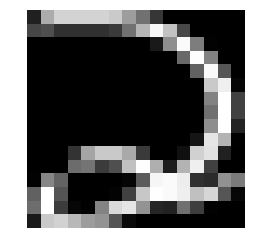

la cual es un 2


Y si miramos lo que contiene, veremos que
x[a,:] = 
[ 0.12941177  0.67450982  0.83137262  0.83137262  0.83137262  0.83137262
  0.79215693  0.6156863   0.44313729  0.21176472  0.          0.          0.
  0.          0.          0.          0.27450982  0.30588236  0.19215688
  0.19215688  0.19215688  0.19215688  0.227451    0.44705886  0.70980394
  0.97254908  0.76078439  0.28235295  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.09803922  0.55686277  0.98039222  0.49019611
  0.00784314  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.41568631  0.99215692  0.50980395  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.38039219  0.98039222  0.33725491
  0.          0.          

In [27]:
#bloque 3

x = data['X_entrena']
y = data['T_entrena']

a = np.random.randint(0, y.shape[0]) # selecciona al azar un número entero entre 0 y el número de imagenes (9000)-1

print("-- x es de dimensiones {}".format(x.shape))
print("-- y es de dimensiones {}".format(y.shape))

print("\ny si escogemos la imagen {} veremos".format(a))

plt.imshow(x[a,:].reshape(16,16), cmap=plt.gray())
plt.axis('off')
plt.show()

print("la cual es un {}".format(list(y[a,:]).index(1)))

print("\n\nY si miramos lo que contiene, veremos que")
print("x[a,:] = \n{}\ny[a,:] = \n{}".format(x[a,:], y[a,:]))


O bien, ejecuta este script para ver un grupo grande de imágenes.

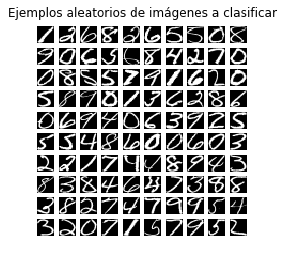

In [28]:
#bloque 4

indices = np.arange(y.shape[0])
np.random.shuffle(indices)
ind = indices[0:100].reshape(10,10)

imagen = np.ones((10 * 16 + 4*11, 10 * 16 + 4*11))
for i in range(10):
    for j in range(10):
        imagen[4 + i * 20: 20 + i * 20, 4 + j * 20: 20 + j * 20] = x[ind[i, j], :].reshape(16,16)
        
plt.imshow(imagen, cmap=plt.gray())
plt.axis('off')
plt.title(u"Ejemplos aleatorios de imágenes a clasificar")


Por último, vamos a hacer una función que agregue la columna de 1's para la x extendida, y simplificar más adelante su uso.

In [29]:
#bloque 5

def extendida(x):
    """
    Agrega una columna de unos a x
    
    """
    return np.c_[np.ones((x.shape[0], 1)), x]

## 2. Unidad *softmax*

En una unidad *softmax*, en lugar de estimar solamente un vector de parámetros, el valor de salida lo descomponemos en $K$ vectores de salida con valores de 1 (si pertenece a esa clase) o cero (si no pertenece). A esto se le conoce como *dummy variable*. En el ejemplo que tenemos, las clases ya se encuentran de esa forma (por eso la salida es un vector de dimensión 10 donde solo uno es 1 y todos los demás valores son 0).  

El problema de aprendizaje para una unidad *softmax* es estimar una matriz de parámetros $\omega$ tal que:

$$
\omega = (\omega^{(1)}, \ldots, \omega^{(K)}) 
$$

donde $\omega^{(k)} = (\omega_0^{(k)}, \ldots, \omega_n^{(k)})^T$ es el vector columna que parametriza la clase $k$. De esta manera, $\omega$ es ahora una matriz de dimensión $(n+1) \times K$. El aporte lineal a cada clase de un objeto $x^{(i)}$ está dado por

$$
z^{(i)} = \omega^T x^{(i)},
$$

el cual es de dimensión $K \times 1$ (un valor por cada clase). La probabilidad de pertenecer a la clase $k$ respecto al resto de las clases está dada por:

$$
\hat{y}_k^{(i)} = softmax(z^{(i)}, k) = \frac{\exp(z_k^{(i)})}{\sum_{j=1}^K \exp(z_j^{(i)})}.
$$


#### Ejercicio 1. Con esta información, realiza la función *softmax*, de manera que si recibe un ndarray de dimensiones $ T \times K$ con $T$ vectores, regrese la matriz de mismas dimensiones con el cálculo *logistica* para cada matriz.

In [32]:
#bloque 6
def softmax(z):
    """
    Calculo de la regresión softmax
    
    @param z: ndarray de dimensión (T, K) donde z[i, :] es el vector de aportes lineales del objeto i
    
    @return: un ndarray de dimensión (T, K) donde cada columna es el calculo softmax de su respectivo vector de entrada.
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    #T,K = z.shape[0],z.shape[1]
    # print("(softmax) z=",z.shape)
    #y_est = np.zeros((z.shape))
    #for i in range(T):
    #    temp = 0    
    #    for j in range(K):
    #        temp = temp + np.exp(z[i,j])
    #    
    #    y_est[i,:] = np.exp(z[i,:])/temp
    y_est = np.exp(z)       
    return y_est / y_est.sum(axis=1).reshape(-1,1)
    #return y/y.mean(axis=0)

Y ahora es necesario implementar la función de pérdida, la cual es la suma de las pérdidas logarítmicas por cada salida de las k regresiones logísticas, la cual puede resumirse como:

$$
Loss(y, \hat{y}) = -\frac{1}{T}\sum_{i=1}^T \sum_{k=1}^K y_k^{(i)} \log(\hat{y}_k^{(i)}),
$$

donde $y_k^{(i)}$ es un valor de 0 o 1 dependiendo si el objeto $i$ pertenece a la clase $k$ o no, mientras que $\hat{y}_k^{(i)}$ es la probabilidad que el objeto $i$ pertenezca a la clase $k$ conociendo $x^{(i)}$ y parametrizado por $\omega$, 
$$
\hat{y}^{(i)} = \Pr(y^{(i)} = k \ |\ x^{(i)}; \omega).
$$

#### Ejercicio 2. Implementa la función de pérdida de manera relativamente eficiente, utilizando las facilidades que presenta numpy.

In [33]:
#bloque 7

def perdida(w, x, y):
    """
    Calcula el costo para la regresión softmax parametrizada por theta, con el conjunto de datos dado por (x, y)    
    @param w: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos
    @param y: ndarray de dimensión (T, K) con la clase por cada dato    
    @return: Un valor flotante    
    """
    T, K = y.shape
    n = x.shape[1] - 1    
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    #z = x.dot(w)
    #y_est = softmax(z)
    #aux = 0
    #for i in range(T):        
    #    for k in range(K):            
    #        aux = aux + y[i,k]*np.log(y_est[i,k])
    #return -aux/T
    z = x.dot(w)
    y_est = softmax(z)
    return -np.sum(np.log(y_est[np.where(y==1)]))/T
####################################################################################
def test_perdida():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)
    w = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    print("pérdida = ",perdida(w,x,y))
    assert perdida(w, x, y) < 0.1
    return "Pasó la prueba"    
###################################################################################
print(test_perdida())

pérdida =  0.0815493381572
Pasó la prueba


#### Ejercicio 3. Implementa la función para predecir el valor de $\hat{y}$ estimada.

In [34]:
#bloque 8

def predice(w, x):
    """
    Prediccion de y_hat a partir de la matriz omega para los valores de x
    
    @param w: ndarray de dimensión (n+1, K) con los parámetros
    @param x: ndarray de dimensión (T, n+1) con los datos

    @return: ndarray de dimensión (T, K) con la clase predecida por cada dato (unos y ceros)
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    
    Py = softmax(x.dot(w))
    return np.where(Py == Py.max(axis=1), 1, 0) 

####################################################################################################
def prueba_prediccion():
    x = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    y = np.eye(4)

    w = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    print('abs((y - predice(w, x)).sum())=',abs((y - predice(w, x)).sum()))
    assert abs((y - predice(w, x)).sum()) < 1e-12 
    return("Pasó la prueba")
####################################################################################################
print(prueba_prediccion())

abs((y - predice(w, x)).sum())= 0.0
Pasó la prueba


Y por último tenemos que implementar el gradiente para poder utilizar los métodos de optimización (ya sea por descenso de gradiente o por algún método de optimización.

El gradiente se obtiene a partir de las derivadas parciales:

$$
\frac{\partial Loss(y, \hat{y})}{\partial \omega_j^{(k)}} = - \frac{1}{T} \sum_{i = 1}^T \left(y_k^{(i)} -   \hat{y}_k^{i}\right) x_j^{(i)},
$$

Esto se puede resolver en forma matricial como

$$
\nabla_\omega Loss(y, \hat{y}) = - \frac{1}{T} X^T (Y - \hat{Y})
$$

#### Ejercicio 4. Implementa el gradiente de la manera que menos se dificulte.

In [35]:
#bloque 9

def gradiente(w, X, Y):
    """
    Calculo del gradiente para el problema de regresión softmax
    
    @param w: ndarray de dimensión (n+1, K) con los parámetros
    @param X: ndarray de dimensión (T, n+1) con los datos
    @param Y: ndarray de dimensión (T, K) con la clase por cada dato
    
    @return: Un ndarray de mismas dimensiones que theta
    
    """
    #--------------------------------------------------------------------------------
    # AGREGA AQUI TU CÓDIGO
    #--------------------------------------------------------------------------------
    T = X.shape[0]
    y_est = softmax(X.dot(w))    
    
    return -X.T.dot( Y - y_est )/T #np.where(y_est == y_est.max(axis=0), y-y_est, 0))/T 
      
#--------------------------------------------------------------------------------
def prueba_gradiente():
    X = np.array([[1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
    Y = np.eye(4)
    w = np.array([[3, -4, -4],[-1, -1, 3], [.01, 3, -10], [-5, 5, 5]]).T
    
    g = gradiente(w,X,Y)
    print('g=',g)
    print('\n np.abs(g).max()=',np.abs(g).max())

    assert np.abs(g).max() < 0.05
    return "Pasó la prueba"
#--------------------------------------------------------------------------------
print(prueba_gradiente())    

g= [[ -1.38890477e-03  -2.87198135e-02  -5.48222482e-03   3.55909431e-02]
 [  4.23176327e-03   6.04900322e-03  -1.72446023e-02   6.96383579e-03]
 [  1.05136068e-02  -3.45560964e-02   2.83264084e-06   2.40396569e-02]]

 np.abs(g).max()= 0.0355909430876
Pasó la prueba


Ahora si, ya nos encontramos en capacidad para realizar el aprendizaje en una unidad softmax.

#### Ejercicio 5. Implementa la regresión logística utilizando el método de descenso de gradiente. Utiliza el método de aprendizaje programado para la neurona logistica y completa los comentarios de la función de forma que quede bien documentada.

In [41]:
#bloque 10

def dg_softmax(w, x, y, epsilon, max_epoch=1000, tol=0.001, errores=True):
    """
    Descenso de gradiente por lotes para la clasificación softmax
    
    AGREGA AQUI LA DOCUMENTACIÓN
    @param x: ndarray de dimension [T, n + 1] con los datos de entrada
    @param y: ndarray de dimension [T, 1] con los datos de salida
    @param w_ini: ndarray de dimension [n + 1, T] con los parámetros iniciales
    @param epsilon: flotante con tamaño de paso o tasa de aprendizaje.
    @param max_epoch: número maximo de épocas que durará el entrenamiento
    @param tol: flotante que ayuda a terminar el ciclo antes del numero de iteraciones dado
    @param errores: logico, indica si se van a guardar los errores obtenidos en cada epoch 
    
    @return: w, historial donde w es un ndarray de la dimensión de w_ini con la w final, 
             mientras que historial es un ndarray de dimensión [num_iter, 1] con el costo en cada iteración.
    """
    #historial = [] if errores else None
    
    #w = w_ini.copy()
    #for epoch in range(max_epoch):
    #    inc_w = gradiente(w, x, y)
    #    if inc_w.max() < tol:
    #        break
    #    w += epsilon * inc_w
    #    historial.append(perdida(w,x,y))
    #return w, historial  
    
    historial = np.zeros((max_epoch)) if errores else None
        
    for epoch in range(max_epoch):
        #--------------------------------------------------------------------------------
        # AGREGA AQUI TU CÓDIGO
        #--------------------------------------------------------------------------------
        
        Z=x.dot(w)
        y_est=softmax(Z)
        N=x.shape[0]
        w+=(epsilon/N)*(x.T.dot((y-y_est)*y))

        if errores:
            historial[epoch] = perdida(w, x, y)
        #--------------------------------------------------------------------------------
        
    return w, historial
    
    

Pero para utilizar el descenso de gradiente hay que ajustar un valor de $\epsilon$.

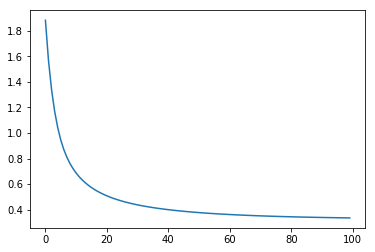

In [42]:
#bloque 11

# Ajusta un valor de epsilon razonable

epsilon_prueba = 0.9

T, K = y.shape
n = x.shape[1]

w = 0.1 * (np.random.random((n + 1, K)) - 0.5)
w, loss_hist = dg_softmax(w, extendida(x), y, epsilon=epsilon_prueba, max_epoch=100,tol=1e-1, errores=True)
plt.plot(loss_hist)



y para probarlo vamos a aprender a clasificar a los dígitos de nuestra base de datos


In [48]:
#bloque 12

w = 0.1 * (np.random.random((n + 1, K)) - 0.5)
w, e_hist = dg_softmax(w, extendida(x), y, epsilon_prueba, max_epoch=1000)

print("El costo de la solución final es de {}".format(perdida(w, extendida(x), y)))

y_estimada = predice(w, extendida(x))
errores = np.where(y.argmax(axis=1) == y_estimada.argmax(axis=1), 0, 1)
#errores = np.abs(y - y_estimada).sum()/2
print(errores)
print("\nLos datos utilizados para el aprendizaje mal clasificados son el {}%".format(errores.mean()))

# Esto solo es para hacerla más emocionante
x_test = data['X_valida']
y_test = data['T_valida']
y_estimada_T = predice(w, extendida(x_test))
#errores = np.abs(y_test - y_estimada_T).sum()/2
errores = np.where(y_test.argmax(axis=1) == y_estimada_T.argmax(axis=1), 0, 1)

print("\nY con los datos de prueba el error es del {}%".format(100*errores.mean()))



El costo de la solución final es de 0.49659694422624945


C:\Users\Edelmira\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


AxisError: axis 1 is out of bounds for array of dimension 1

¿Será esta la mejor solución? ¿Será una buena solución? Por esto no hay que preocuparse mucho todavía, lo vamos a revisar más adelante en el curso. Se espera con la unidad *softmax* poder clasificar correctamente más del 95% de los datos de entrenamiento. 